In [ ]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse, RetrievalMode
from qdrant_client import QdrantClient, models
from langchain_huggingface import HuggingFaceEmbeddings
import os

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

from langchain_core.tools import Tool
from langchain.agents import create_agent
from langchain_groq import ChatGroq

from langgraph.graph import StateGraph, START, END
from typing import List, Annotated
from dataclasses import dataclass
from langchain_core.messages import AnyMessage, HumanMessage
from langgraph.graph.message import add_messages
from pprint import pprint

In [31]:
client = QdrantClient(
    url=os.getenv('QDRANT_API_URL'),
    api_key= os.getenv('QDRANT_API_KEY')
)

In [32]:
qdrantdb = QdrantVectorStore(
    collection_name=os.getenv('COLLECTIONNAME'),
    embedding=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L12-v2" ),
    sparse_embedding=FastEmbedSparse(model_name="Qdrant/bm25"),
    retrieval_mode=RetrievalMode.HYBRID,
    client=client,
)

qdrantdb_retriver = qdrantdb.as_retriever()

In [33]:
def func_retriver(query: str) -> str:

    docs  = qdrantdb_retriver.invoke(query)
    return '\n\n'.join([doc.page_content for doc in docs])

powerbitool = Tool(
    name = "PowerBITool",
    description= "Power BI Retriver",
    func= func_retriver
)

wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=2000))
tools = [powerbitool, wiki_tool]



In [34]:
llm = ChatGroq(model="openai/gpt-oss-20b")
system_prompt = "You are a helpful assistant that can access tools to answer questions."

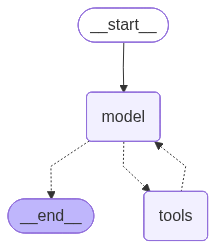

In [35]:
agent = create_agent(
    model= llm,
    tools=tools,
    system_prompt=system_prompt
)

agent

In [36]:
@dataclass
class myReactBot():

    messages: Annotated[List[AnyMessage], add_messages]

In [37]:
graph = StateGraph(myReactBot)

graph.add_node("llmagent", agent)

graph.add_edge(START, "llmagent")
graph.add_edge("llmagent", END)

graph_builder = graph.compile()

In [40]:
msg = "tell me top 5 power bi interview questions"
result = graph_builder.invoke(myReactBot(messages=[HumanMessage(msg)]))

for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

tell me top 5 power bi interview questions
================================== Ai Message ==================================

Below are five of the most frequently asked Power BI interview questions, along with concise answers that highlight the key concepts you should know. Feel free to expand on each point with your own examples or screenshots during an interview.

| # | Question | Why it’s asked | Key points to cover |
|---|----------|----------------|---------------------|
| 1 | **What is Power BI and how does it fit into the Microsoft BI ecosystem?** | Sets the stage – interviewer wants to gauge your overall understanding. | • Power BI = cloud‑based analytics platform (Power BI Desktop, Service, Mobile, Gateway).<br>• Integrates with Azure services (Data Lake, Synapse, Machine Learning), Excel, SharePoint, Teams.<br>• Enables end‑to‑end data flow: ingest → transform (Power Query) → model (DAX) → visua